In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import os
import pandas as pd

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for squad contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/squad/squad.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
import json
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# os.listdir('drive/MyDrive/Quotes')

In [ ]:
%cd /content/drive/MyDrive/Quotes

/content/drive/MyDrive/Quotes


In [ ]:
os.listdir()

['quotes_data.csv',
 'quotes.ipynb',
 'models',
 'dataloaders',
 'tag_types_encoded.json',
 'prep_quotes.csv']

# Data Preprocessing

In [ ]:
df = pd.read_csv('quotes_data.csv')

In [ ]:
df.shape

(101243, 5)

In [ ]:
df.isna().sum()

Quote       0
Author      0
Category    0
Url         0
Tags        0
dtype: int64

In [ ]:
df.duplicated().sum()

32

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
df.reset_index(drop = True, inplace = True)

In [ ]:
df.shape

(101211, 5)

In [ ]:
df.columns

Index(['Quote', 'Author', 'Category', 'Url', 'Tags'], dtype='object')

In [ ]:
tags_list = df.Tags.to_list()
tag_count = {}
for tags in tags_list:
  tag_list = eval(tags)
  for tag in tag_list:
    if tag in tag_count.keys():
      tag_count[tag] += 1
    else:
      tag_count[tag] = 1
print(len(tag_count))

9129


In [ ]:
print(tag_count.values())

dict_values([1871, 1295, 201, 366, 9, 840, 3249, 2443, 383, 284, 813, 12, 17, 529, 643, 394, 3091, 449, 170, 127, 1544, 33, 478, 678, 49, 83, 1379, 159, 909, 701, 5, 384, 2, 165, 248, 1512, 26, 156, 804, 2, 47, 1473, 41, 65, 122, 27, 58, 4, 35, 4, 1, 3257, 213, 62, 638, 53, 27, 2364, 4304, 16, 7553, 2112, 134, 62, 5508, 1268, 115, 283, 5, 844, 8270, 527, 3, 2, 75, 404, 120, 121, 3, 1, 1, 60, 1, 179, 6159, 109, 123, 1185, 2761, 1671, 866, 65, 311, 1556, 24, 2324, 4505, 2032, 390, 5807, 2118, 825, 498, 46, 375, 6176, 63, 166, 91, 605, 419, 695, 2089, 487, 967, 5, 1669, 106, 636, 19, 12, 1610, 12, 3, 46, 664, 21, 221, 668, 3, 1163, 6, 1996, 97, 144, 2, 759, 1810, 20, 48, 12, 9, 1, 19, 160, 39, 166, 14, 255, 111, 485, 7, 202, 220, 66, 43, 14, 94, 964, 1265, 154, 1608, 681, 5, 134, 420, 87, 55, 7, 2, 1502, 32, 28, 54, 92, 808, 727, 27, 4, 17, 8, 162, 37, 2292, 1813, 612, 760, 29, 490, 251, 929, 7, 559, 13, 133, 2577, 11, 3, 430, 76, 92, 101, 440, 1, 2026, 12, 48, 374, 20, 7, 648, 489, 191, 

In [ ]:
th = int(len(df)*0.001)
print(th)

101


In [ ]:
rare_tags = [tags for tags, value in tag_count.items() if value < th]

In [ ]:
len(rare_tags)

8454

In [ ]:
total_tags = list(tag_count.keys())

In [ ]:
print(type(total_tags), type(rare_tags))

<class 'list'> <class 'list'>


In [ ]:
actual_tags = list(set(total_tags) - set(rare_tags))

In [ ]:
len(actual_tags)

675

In [ ]:
print(sorted(actual_tags))

['Ability', 'About', 'Accept', 'Achieve', 'Achievement', 'Act', 'Acting', 'Action', 'Advice', 'Afraid', 'Again', 'Age', 'Ahead', 'Aim', 'Alive', 'Alone', 'Always', 'Am', 'Amazing', 'Ambition', 'America', 'American', 'Anger', 'Angry', 'Anniversary', 'Any', 'Anything', 'Architecture', 'Army', 'Art', 'Artist', 'Attention', 'Attitude', 'Away', 'Back', 'Bad', 'Balance', 'Battle', 'Beautiful', 'Beauty', 'Because', 'Become', 'Been', 'Before', 'Beginning', 'Behavior', 'Being', 'Belief', 'Believe', 'Best', 'Better', 'Beyond', 'Bible', 'Big', 'Birth', 'Birthday', 'Black', 'Blessed', 'Blood', 'Body', 'Book', 'Born', 'Brain', 'Brainy', 'Brave', 'Bring', 'Brother', 'Build', 'Building', 'Business', 'Busy', 'Cannot', 'Car', 'Care', 'Career', 'Celebrate', 'Challenges', 'Chance', 'Change', 'Character', 'Child', 'Childhood', 'Children', 'Choice', 'Choices', 'Christmas', 'Church', 'Cinema', 'City', 'Cold', 'College', 'Come', 'Comedy', 'Commitment', 'Communication', 'Community', 'Company', 'Competition', 

In [ ]:
tags_list = df.Tags.to_list()
revised_tag_list = []
indices_to_drop = []

for idx, tags in enumerate(tags_list):
  tag_list = eval(tags)
  revised_tags = []

  for tag in tag_list:
    if tag in actual_tags:
      revised_tags.append(tag)

  if len(revised_tags) == 0:
    indices_to_drop.append(idx)
  else:
    revised_tag_list.append(revised_tags)

df = df.drop(indices_to_drop).reset_index(drop=True)
df['revised_tags'] = revised_tag_list
df.shape

(101201, 6)

In [ ]:
df.tail()

,Quote,Author,Category,Url,Tags,revised_tags
101196,A manager is not a person who can do the work better than his men; he is a person who can get his men to do the work better than he can.,Frederick W. Smith,Work,https://www.brainyquote.com/quotes/frederick_w_smith_201583?src=t_work,"['Work', 'Men', 'Better', 'Person', 'Who']","[Work, Men, Better, Person, Who]"
101197,The sweat of hard work is not to be displayed. It is much more graceful to appear favored by the gods.,Maxine Hong Kingston,Work,https://www.brainyquote.com/quotes/maxine_hong_kingston_204858?src=t_work,"['Work', 'Hard Work', 'Hard', 'Sweat', 'More']","[Work, Hard Work, Hard, More]"
101198,"Identify your niche and dominate it. And when I say dominate, I just mean work harder than anyone else could possibly work at it.",Nate Parker,Work,https://www.brainyquote.com/quotes/nate_parker_538454?src=t_work,"['Work', 'Dominate', 'Niche', 'Mean', 'Just']","[Work, Mean, Just]"
101199,"Loyal and efficient work in a great cause, even though it may not be immediately recognized, ultimately bears fruit.",Jawaharlal Nehru,Work,https://www.brainyquote.com/quotes/jawaharlal_nehru_390491?src=t_work,"['Work', 'Great', 'Fruit', 'Even', 'Cause']","[Work, Great, Fruit, Even]"
101200,"Fabrics such as raw silk, velvet, shimmer, satin and georgette work well for the wedding season.",Masaba Gupta,Work,https://www.brainyquote.com/quotes/masaba_gupta_1125086?src=t_work,"['Work', 'Wedding', 'Fabrics', 'Velvet', 'Well']","[Work, Wedding, Well]"


In [ ]:
revised_tags_list = df.revised_tags.to_list()
revised_tag_count = {}
for tags in revised_tags_list:
  tag_list = tags
  for tag in tag_list:
    if tag in revised_tag_count.keys():
      revised_tag_count[tag] += 1
    else:
      revised_tag_count[tag] = 1
print(f"Number of Genres: {len(revised_tag_count)}")
print(revised_tag_count)

Number of Genres: 675
{'Age': 1871, 'Mind': 1295, 'Matter': 201, 'Over': 366, 'Birthday': 840, 'Man': 3249, 'Never': 2443, 'Woman': 383, 'Youth': 284, 'Young': 813, 'Help': 529, 'Old': 643, 'Get': 394, 'Men': 3091, 'Grow': 449, 'Attention': 170, 'Pay': 127, 'Strength': 1544, 'Opportunity': 478, 'Remember': 678, 'Morning': 1379, 'Wake Up': 159, 'School': 909, 'Country': 701, 'Happy': 384, 'Child': 165, 'Lie': 248, 'Live': 1512, 'Old Age': 156, 'Place': 804, 'Nothing': 1473, 'High': 122, 'Best': 3257, 'Improve': 213, 'Soul': 638, 'Change': 2364, 'Great': 4304, 'People': 7553, 'I Am': 2112, 'Strange': 134, 'Me': 5508, 'Try': 1268, 'Environment': 115, 'Growing Up': 283, 'Up': 844, 'Life': 8270, 'End': 527, 'Wish': 404, 'Minds': 120, 'Order': 121, 'Very': 179, 'Time': 6159, 'Habit': 109, 'Busy': 123, 'Person': 1185, 'Women': 2761, 'Myself': 1671, 'Beautiful': 866, 'Purpose': 311, 'Learning': 1556, 'Art': 2324, 'Work': 4505, 'Nature': 2032, 'Gift': 390, 'Good': 5807, 'Believe': 2118, 'True':

In [ ]:
encode_tag_types = {key: idx for idx, (key, value) in enumerate(revised_tag_count.items())}
with open("tag_types_encoded.json", "w") as fp:
  json.dump(encode_tag_types, fp)

In [ ]:
print(encode_tag_types)

{'Age': 0, 'Mind': 1, 'Matter': 2, 'Over': 3, 'Birthday': 4, 'Man': 5, 'Never': 6, 'Woman': 7, 'Youth': 8, 'Young': 9, 'Help': 10, 'Old': 11, 'Get': 12, 'Men': 13, 'Grow': 14, 'Attention': 15, 'Pay': 16, 'Strength': 17, 'Opportunity': 18, 'Remember': 19, 'Morning': 20, 'Wake Up': 21, 'School': 22, 'Country': 23, 'Happy': 24, 'Child': 25, 'Lie': 26, 'Live': 27, 'Old Age': 28, 'Place': 29, 'Nothing': 30, 'High': 31, 'Best': 32, 'Improve': 33, 'Soul': 34, 'Change': 35, 'Great': 36, 'People': 37, 'I Am': 38, 'Strange': 39, 'Me': 40, 'Try': 41, 'Environment': 42, 'Growing Up': 43, 'Up': 44, 'Life': 45, 'End': 46, 'Wish': 47, 'Minds': 48, 'Order': 49, 'Very': 50, 'Time': 51, 'Habit': 52, 'Busy': 53, 'Person': 54, 'Women': 55, 'Myself': 56, 'Beautiful': 57, 'Purpose': 58, 'Learning': 59, 'Art': 60, 'Work': 61, 'Nature': 62, 'Gift': 63, 'Good': 64, 'Believe': 65, 'True': 66, 'Light': 67, 'Night': 68, 'Love': 69, 'Does': 70, 'Everything': 71, 'How': 72, 'You': 73, 'Success': 74, 'Start': 75, 'C

In [ ]:
cat_tag_list = []
rev_tags_list = df.revised_tags.to_list()

for tags in rev_tags_list:
  cat_tags_list = [0]* len(encode_tag_types)
  for tag in tags:
    tag_type_idx = encode_tag_types[tag]
    cat_tags_list[tag_type_idx] = 1
  cat_tag_list.append(cat_tags_list)

In [ ]:
print(cat_tag_list[:5])

[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
df['labels'] = cat_tag_list

In [ ]:
df.head()

,Quote,Author,Category,Url,Tags,revised_tags,labels
0,"Age is an issue of mind over matter. If you don't mind, it doesn't matter.",Mark Twain,Age,https://www.brainyquote.com/quotes/mark_twain_103892?src=t_age,"['Age', 'Mind', 'Matter', 'Over', 'Issue']","[Age, Mind, Matter, Over]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,A diplomat is a man who always remembers a woman's birthday but never remembers her age.,Robert Frost,Age,https://www.brainyquote.com/quotes/robert_frost_107290?src=t_age,"['Birthday', 'Age', 'Man', 'Never', 'Woman']","[Birthday, Age, Man, Never, Woman]","[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Youth is wasted on the young.,George Bernard Shaw,Age,https://www.brainyquote.com/quotes/george_bernard_shaw_131494?src=t_age,"['Age', 'Youth', 'Young', 'Wasted']","[Age, Youth, Young]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,"You can't help getting older, but you don't have to get old.",George Burns,Age,https://www.brainyquote.com/quotes/george_burns_103932?src=t_age,"['Age', 'Getting Older', 'Help', 'Old', 'Get']","[Age, Help, Old, Get]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,"As I grow older, I pay less attention to what men say. I just watch what they do.",Andrew Carnegie,Age,https://www.brainyquote.com/quotes/andrew_carnegie_106123?src=t_age,"['Age', 'Men', 'Grow', 'Attention', 'Pay']","[Age, Men, Grow, Attention, Pay]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [ ]:
df.to_csv("prep_quotes.csv", index = False)

# Dataloader

In [ ]:
os.listdir()

['quotes_data.csv',
 'quotes.ipynb',
 'models',
 'dataloaders',
 'prep_quotes.csv',
 'tag_types_encoded.json']

In [ ]:
df = pd.read_csv('prep_quotes.csv')

In [ ]:
df.head()

,Quote,Author,Category,Url,Tags,revised_tags,labels
0,"Age is an issue of mind over matter. If you don't mind, it doesn't matter.",Mark Twain,Age,https://www.brainyquote.com/quotes/mark_twain_103892?src=t_age,"['Age', 'Mind', 'Matter', 'Over', 'Issue']","['Age', 'Mind', 'Matter', 'Over']","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,A diplomat is a man who always remembers a woman's birthday but never remembers her age.,Robert Frost,Age,https://www.brainyquote.com/quotes/robert_frost_107290?src=t_age,"['Birthday', 'Age', 'Man', 'Never', 'Woman']","['Birthday', 'Age', 'Man', 'Never', 'Woman']","[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,Youth is wasted on the young.,George Bernard Shaw,Age,https://www.brainyquote.com/quotes/george_bernard_shaw_131494?src=t_age,"['Age', 'Youth', 'Young', 'Wasted']","['Age', 'Youth', 'Young']","[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,"You can't help getting older, but you don't have to get old.",George Burns,Age,https://www.brainyquote.com/quotes/george_burns_103932?src=t_age,"['Age', 'Getting Older', 'Help', 'Old', 'Get']","['Age', 'Help', 'Old', 'Get']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,"As I grow older, I pay less attention to what men say. I just watch what they do.",Andrew Carnegie,Age,https://www.brainyquote.com/quotes/andrew_carnegie_106123?src=t_age,"['Age', 'Men', 'Grow', 'Attention', 'Pay']","['Age', 'Men', 'Grow', 'Attention', 'Pay']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
with open('tag_types_encoded.json', 'r') as file:
  tag_encoder = json.load(file)

In [ ]:
print(tag_encoder)

{'Age': 0, 'Mind': 1, 'Matter': 2, 'Over': 3, 'Birthday': 4, 'Man': 5, 'Never': 6, 'Woman': 7, 'Youth': 8, 'Young': 9, 'Help': 10, 'Old': 11, 'Get': 12, 'Men': 13, 'Grow': 14, 'Attention': 15, 'Pay': 16, 'Strength': 17, 'Opportunity': 18, 'Remember': 19, 'Morning': 20, 'Wake Up': 21, 'School': 22, 'Country': 23, 'Happy': 24, 'Child': 25, 'Lie': 26, 'Live': 27, 'Old Age': 28, 'Place': 29, 'Nothing': 30, 'High': 31, 'Best': 32, 'Improve': 33, 'Soul': 34, 'Change': 35, 'Great': 36, 'People': 37, 'I Am': 38, 'Strange': 39, 'Me': 40, 'Try': 41, 'Environment': 42, 'Growing Up': 43, 'Up': 44, 'Life': 45, 'End': 46, 'Wish': 47, 'Minds': 48, 'Order': 49, 'Very': 50, 'Time': 51, 'Habit': 52, 'Busy': 53, 'Person': 54, 'Women': 55, 'Myself': 56, 'Beautiful': 57, 'Purpose': 58, 'Learning': 59, 'Art': 60, 'Work': 61, 'Nature': 62, 'Gift': 63, 'Good': 64, 'Believe': 65, 'True': 66, 'Light': 67, 'Night': 68, 'Love': 69, 'Does': 70, 'Everything': 71, 'How': 72, 'You': 73, 'Success': 74, 'Start': 75, 'C

In [ ]:
labels = list(tag_encoder.keys())

In [ ]:
print(labels)

['Age', 'Mind', 'Matter', 'Over', 'Birthday', 'Man', 'Never', 'Woman', 'Youth', 'Young', 'Help', 'Old', 'Get', 'Men', 'Grow', 'Attention', 'Pay', 'Strength', 'Opportunity', 'Remember', 'Morning', 'Wake Up', 'School', 'Country', 'Happy', 'Child', 'Lie', 'Live', 'Old Age', 'Place', 'Nothing', 'High', 'Best', 'Improve', 'Soul', 'Change', 'Great', 'People', 'I Am', 'Strange', 'Me', 'Try', 'Environment', 'Growing Up', 'Up', 'Life', 'End', 'Wish', 'Minds', 'Order', 'Very', 'Time', 'Habit', 'Busy', 'Person', 'Women', 'Myself', 'Beautiful', 'Purpose', 'Learning', 'Art', 'Work', 'Nature', 'Gift', 'Good', 'Believe', 'True', 'Light', 'Night', 'Love', 'Does', 'Everything', 'How', 'You', 'Success', 'Start', 'Children', 'Who', 'Those', 'Face', 'Long', 'Important', 'Stop', 'Because', 'Heart', 'Always', 'Same', 'She', 'More', 'Something', 'Whatever', 'Early', 'Happens', 'Lose', 'Friend', 'Enemy', 'Only', 'Sad', 'Nice', 'Look', 'Father', 'Blood', 'Wife', 'Trust', 'Your', 'Our', 'Grace', 'Money', 'Healt

In [ ]:
def convert_to_int(arr):
  arr = np.array(eval(arr))
  return arr.astype(np.int64)

In [ ]:
df['labels'] = df['labels'].apply(convert_to_int)

In [ ]:
df.head()

,Quote,Author,Category,Url,Tags,revised_tags,labels
0,"Age is an issue of mind over matter. If you don't mind, it doesn't matter.",Mark Twain,Age,https://www.brainyquote.com/quotes/mark_twain_103892?src=t_age,"['Age', 'Mind', 'Matter', 'Over', 'Issue']","['Age', 'Mind', 'Matter', 'Over']","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,A diplomat is a man who always remembers a woman's birthday but never remembers her age.,Robert Frost,Age,https://www.brainyquote.com/quotes/robert_frost_107290?src=t_age,"['Birthday', 'Age', 'Man', 'Never', 'Woman']","['Birthday', 'Age', 'Man', 'Never', 'Woman']","[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,Youth is wasted on the young.,George Bernard Shaw,Age,https://www.brainyquote.com/quotes/george_bernard_shaw_131494?src=t_age,"['Age', 'Youth', 'Young', 'Wasted']","['Age', 'Youth', 'Young']","[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,"You can't help getting older, but you don't have to get old.",George Burns,Age,https://www.brainyquote.com/quotes/george_burns_103932?src=t_age,"['Age', 'Getting Older', 'Help', 'Old', 'Get']","['Age', 'Help', 'Old', 'Get']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,"As I grow older, I pay less attention to what men say. I just watch what they do.",Andrew Carnegie,Age,https://www.brainyquote.com/quotes/andrew_carnegie_106123?src=t_age,"['Age', 'Men', 'Grow', 'Attention', 'Pay']","['Age', 'Men', 'Grow', 'Attention', 'Pay']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


# DistilRoberta Base

In [ ]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls = model_cls, config = config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded = True, vocab = labels))
dblock = DataBlock(blocks = blocks, get_x = ColReader('Quote'), get_y = ColReader('labels'), splitter = RandomSplitter(valid_pct = 0.2, seed = 42))

In [ ]:
dls = dblock.dataloaders(df, bs = 32)

In [ ]:
dls_path = "dataloaders"
if not os.path.exists(dls_path):
  os.makedirs(dls_path)
torch.save(dls, f"dataloaders/dls-multilabel-quote-classifier-{model_name}.pkl")

In [ ]:
os.listdir('models')

['quote-classifier-distilroberta-base-stage-0.pth',
 'quote-classifier-distilroberta-base-stage-0.pkl',
 'quote-classifier-distilroberta-base-stage-1.pth',
 'quote-classifier-distilroberta-base-stage-1.pkl']

In [ ]:
dls.vocab

['Age', 'Mind', 'Matter', 'Over', 'Birthday', 'Man', 'Never', 'Woman', 'Youth', 'Young', 'Help', 'Old', 'Get', 'Men', 'Grow', 'Attention', 'Pay', 'Strength', 'Opportunity', 'Remember', 'Morning', 'Wake Up', 'School', 'Country', 'Happy', 'Child', 'Lie', 'Live', 'Old Age', 'Place', 'Nothing', 'High', 'Best', 'Improve', 'Soul', 'Change', 'Great', 'People', 'I Am', 'Strange', 'Me', 'Try', 'Environment', 'Growing Up', 'Up', 'Life', 'End', 'Wish', 'Minds', 'Order', 'Very', 'Time', 'Habit', 'Busy', 'Person', 'Women', 'Myself', 'Beautiful', 'Purpose', 'Learning', 'Art', 'Work', 'Nature', 'Gift', 'Good', 'Believe', 'True', 'Light', 'Night', 'Love', 'Does', 'Everything', 'How', 'You', 'Success', 'Start', 'Children', 'Who', 'Those', 'Face', 'Long', 'Important', 'Stop', 'Because', 'Heart', 'Always', 'Same', 'She', 'More', 'Something', 'Whatever', 'Early', 'Happens', 'Lose', 'Friend', 'Enemy', 'Only', 'Sad', 'Nice', 'Look', 'Father', 'Blood', 'Wife', 'Trust', 'Your', 'Our', 'Grace', 'Money', 'Healt

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"You can scroll through my iTunes and I've got everything. I've got Ace Hood, Alt-J, Annie Lennox, Arctic Monkeys, Beanie Sigel, the Beatles, Beth Hart, Big Sean, Bob Dylan, Bon Iver, Chief Keef, Coldplay, the Flaming Lips, Mariah Carey, Miley Cyrus, Nicki Minaj, OutKast, Pet Shop Boys, Peter Gabriel, the Smiths, and the list goes on from there.","[Everything, Big, Pet]"
1,"I was always a fan of the old-style comics. I loved vaudeville. I loved Milton Berle, Dick Shawn, Phyllis Diller, Don Rickles, Charlie Callas, all those guys. Hilarious. I love the Bing Crosby and Bob Hope movies, and Abbott & Costello. My television influences were 'Monty Python's Flying Circus,' 'Benny Hill,' and 'Hee Haw.'","[Love, Hope, Loved, Movies]"
2,"It's depression. You can't put it into words. You get stuck and time passes by. I'm stood there on the edge of a cliff, can't go back and can't go forward. Days go by. I'm still in the same place. Everyone else's life goes on, but you're stuck. You try and try and try and I don't know how, but you came out of it eventually.","[Try, Life, Time, Words]"
3,"I liked the idea of creating a new pop-culture, folkloric hero character that I created with 'Django' that I think's gonna last for a long time. And I think as the generations go on and everything, you know, my hope is it can be a rite of passage for black fathers and their sons. Like, when are they old enough to watch 'Django Unchained'?","[Time, Long, Black, Hope, Character]"


In [ ]:
doc(partial)

In [ ]:
model = BaseModelWrapper(hf_model)

acc = partial(accuracy_multi)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

Stage - 0

SuggestedLRs(slide=0.0010000000474974513, valley=0.0002290867705596611)

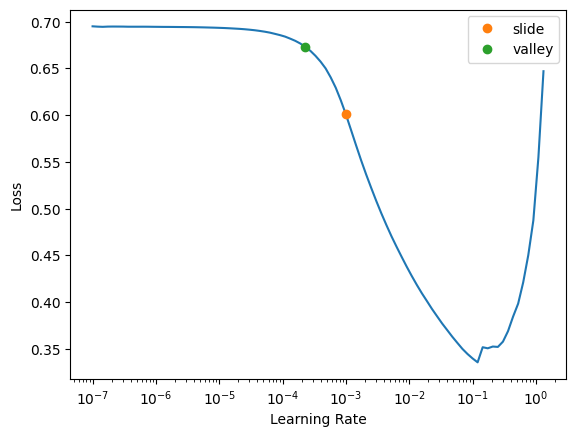

In [ ]:
learner.freeze()
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
lr = (0.0010000000474974513 + 0.0002290867705596611)/2
print(lr)

0.0006145434090285562


In [ ]:
learner.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.021057,0.019537,0.995917,02:58
1,0.015334,0.014217,0.996760,02:56


In [ ]:
model_path = "models"
if not os.path.exists(model_path):
  os.makedirs(model_path)

In [ ]:
learner.save(f"quote-classifier-{model_name}-stage-0")

Path('models/quote-classifier-distilroberta-stage-0.pth')

In [ ]:
learner.export(f"models/quote-classifier-{model_name}-stage-0.pkl")

Stage - 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.00013182566908653826, valley=1.2022644114040304e-05)

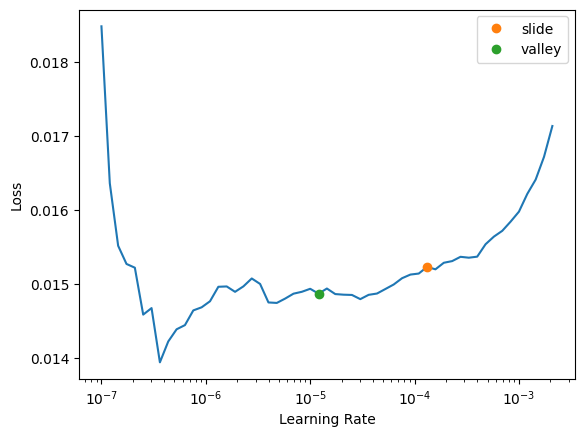

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
lr = (0.00013182566908653826 + 1.2022644114040304e-05)/2
print(lr)

7.192415660028928e-05


In [ ]:
learner.fit_one_cycle(3,lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.010467,0.009456,0.997613,04:46
1,0.007487,0.006732,0.998211,04:48
2,0.006536,0.006090,0.998396,04:49


In [ ]:
learner.save(f"quote-classifier-{model_name}-stage-1")

Path('models/quote-classifier-distilroberta-stage-1.pth')

In [ ]:
learner.export(f"models/quote-classifier-{model_name}-stage-1.pkl")

# BERT

In [ ]:
model_name = "bert-base-uncased"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls = model_cls, config = config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded = True, vocab = labels))
dblock = DataBlock(blocks = blocks, get_x = ColReader('Quote'), get_y = ColReader('labels'), splitter = RandomSplitter(valid_pct = 0.2, seed = 42))

In [ ]:
dls = dblock.dataloaders(df, bs = 32)

In [ ]:
torch.save(dls, f"dataloaders/dls-multilabel-quote-classifier-{model_name}.pkl")

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"it's a funny thing. i'll be in my home town of columbus at a restaurant or something, and the waiter maybe asks,'what do you do?'and i say,'oh, i'm in a band... twenty one pilots,'and he'll say,'cool, i'll check it out. i never heard of them.'and then i say,'in september we're playing the schottenstein center,'and it's like,'what?! '","[Never, Home, Funny, Cool]"
1,"we had an argument, and he told me to be home at midnight, and i said no. and so when i did come home, the door was locked. and i had gotten a set of luggage for graduation that day, and it was on the front porch, packed. he thought that he was going to prove a point and i was going to say,'oh, i'm sorry, daddy, i'm sorry '.","[Day, Home, Door, Graduation]"
2,"write about your experiences! when i moved to l. a., i didn't have any friends, and the office janitor was the person who i saw the most. he would always come in at around 10 : 00 p. m., and i would still be at my desk, so i wrote a play about a first - year tv writer and the friendship that she developed with the janitor. our stories matter.","[Person, She, Friends, Friendship]"
3,"at a certain point, if you still have your marbles and are not faced with serious financial challenges, you have a chance to put your house in order. it's a cliche, but it's underestimated as an analgesic on all levels. putting your house in order, if you can do it, is one of the most comforting activities, and the benefits of it are incalculable.","[Challenges, Chance, Point]"


In [ ]:
model = BaseModelWrapper(hf_model)

acc = partial(accuracy_multi)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

Stage - 0

SuggestedLRs(slide=0.0008317637839354575, valley=0.0003311311302240938)

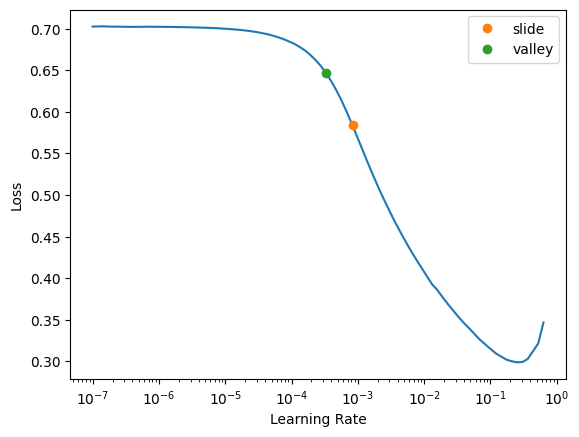

In [ ]:
learner.freeze()
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
lr = (0.0008317637839354575 + 0.0003311311302240938)/2
print(lr)

0.0005814474570797756


In [ ]:
learner.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.031648,0.031621,0.994219,04:49
1,0.029042,0.029243,0.994219,04:44


In [ ]:
learner.save(f"quote-classifier-{model_name}-stage-0")

Path('models/quote-classifier-bert-base-uncased-stage-0.pth')

In [ ]:
learner.export(f"models/quote-classifier-{model_name}-stage-0.pkl")

Stage - 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.0002754228771664202, valley=1.737800812406931e-05)

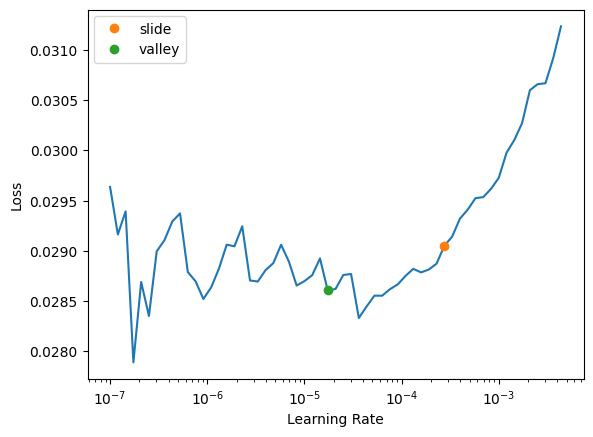

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
lr = (0.0002754228771664202 + 1.737800812406931e-05)/2
print(lr)

0.00014640044264524477


In [ ]:
learner.fit_one_cycle(3,lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.012605,0.012171,0.997356,06:43
1,0.006401,0.006147,0.998466,06:35


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.012605,0.012171,0.997356,06:43
1,0.006401,0.006147,0.998466,06:35


In [ ]:
learner.save(f"quote-classifier-{model_name}-stage-1")

In [ ]:
learner.export(f"models/quote-classifier-{model_name}-stage-1.pkl")

# Inference and F1 score

In [ ]:
df = pd.read_csv('prep_quotes.csv')

In [ ]:
df.columns

Index(['Quote', 'Author', 'Category', 'Url', 'Tags', 'revised_tags', 'labels'], dtype='object')

In [ ]:
df['labels'] = df['labels'].apply(convert_to_int)

In [ ]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)
train_ids, valid_ids = splitter(df)
len(train_ids), len(valid_ids)

(80961, 20240)

In [ ]:
valid_df = df.loc[valid_ids]
valid_df.head()

,Quote,Author,Category,Url,Tags,revised_tags,labels
47647,"We are a country where people of all backgrounds, all nations of origin, all languages, all religions, all races, can make a home. America was built by immigrants.",Hillary Clinton,Home,https://www.brainyquote.com/quotes/hillary_clinton_751721?src=t_home,"['Home', 'America', 'All Religions', 'People']","['Home', 'America', 'People']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
60068,Love is often the fruit of marriage.,Moliere,Marriage,https://www.brainyquote.com/quotes/moliere_380418?src=t_marriage,"['Love', 'Marriage', 'Love Is', 'Fruit', 'Often']","['Love', 'Marriage', 'Love Is', 'Fruit', 'Often']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
8427,I consider my ability to arouse enthusiasm among men the greatest asset I possess. The way to develop the best that is in a man is by appreciation and encouragement.,Charles M. Schwab,Best,https://www.brainyquote.com/quotes/charles_m_schwab_121301?src=t_best,"['Best', 'Men', 'Man', 'Appreciation', 'Enthusiasm']","['Best', 'Men', 'Man']","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
19987,I was dating a guy that was a huge wrestling fan and I'm embarrassed to say it now but I used to make fun of him for watching it.,Torrie Wilson,Dating,https://www.brainyquote.com/quotes/torrie_wilson_177705?src=t_dating,"['Dating', 'Fun', 'Wrestling', 'Now', 'Watching']","['Dating', 'Fun', 'Now']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2831,"United Artists wanted to do records with me. I had no idea, what a rare thing that was... to make an album. And they put a guy with me working on songs, and I got busy with films. I just kind of let it slide. Isn't that amazing?",John Astin,Amazing,https://www.brainyquote.com/quotes/john_astin_249953?src=t_amazing,"['Amazing', 'Busy', 'Me', 'Rare', 'Just']","['Amazing', 'Busy', 'Me', 'Just']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


In [ ]:
with open('tag_types_encoded.json', 'r') as file:
  tag_encoder = json.load(file)

In [ ]:
os.listdir('models')

['quote-classifier-distilroberta-base-stage-0.pkl',
 'quote-classifier-distilroberta-base-stage-0.pth',
 'quote-classifier-distilroberta-base-stage-1.pkl',
 'quote-classifier-distilroberta-base-stage-1.pth',
 'quote-classifier-bert-base-uncased-stage-0.pth',
 'quote-classifier-bert-base-uncased-stage-0.pkl',
 'quote-classifier-bert-base-uncased-stage-1.pth',
 'quote-classifier-bert-base-uncased-stage-1.pkl',
 'tmpzpz2jpqv']

In [ ]:
from sklearn import metrics

def metric_measures(test_df, preds):

  targets = [np.asarray(target) for target in test_df['labels'].to_list()]
  outputs = [np.asarray(pred) for pred in preds]


  accuracy = metrics.accuracy_score(targets, outputs)
  f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
  f1_score_macro = metrics.f1_score(targets, outputs, average='macro')

  print(f"F1 Score (Micro) = {f1_score_micro: .4f}")
  print(f"F1 Score (Macro) = {f1_score_macro: .4f}")

  return

In [ ]:
example = "What you have accomplished in the past is a much stronger example than talking about what you are capable of doing in the future.Actions do speak louder than words!"

### Distil Roberta

In [ ]:
roberta_model_path = "models/quote-classifier-distilroberta-base-stage-1.pkl"
roberta_learner_inf = load_learner(roberta_model_path)

In [ ]:
roberta_learner_inf.blurr_predict(example)[0]['labels']

['Past', 'Future', 'Words']

In [ ]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['Quote']
  labels = roberta_learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(tag_encoder)
  for label in labels:
    pred_genres[tag_encoder[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/20240 [00:00<?, ?it/s]

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) =  0.8449
F1 Score (Macro) =  0.5242


## Bert

In [ ]:
roberta_model_path = "models/quote-classifier-bert-base-uncased-stage-1.pkl"
roberta_learner_inf = load_learner(roberta_model_path)

In [ ]:
roberta_learner_inf.blurr_predict(example)[0]['labels']

['Past', 'Future', 'Words']

In [ ]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=len(valid_df)):
  desc = row['Quote']
  labels = roberta_learner_inf.blurr_predict(desc)[0]['labels']
  pred_genres = [0] * len(tag_encoder)
  for label in labels:
    pred_genres[tag_encoder[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/20240 [00:00<?, ?it/s]

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) =  0.8860
F1 Score (Macro) =  0.6715


# ONNX

In [ ]:
! pip install -q onnxruntime onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 38.2 MB/s eta 0:00:00


In [ ]:
model_path = "models/quote-classifier-bert-base-uncased-stage-1.pkl"
learner_inf = load_learner(model_path)

In [ ]:
classifier = learner_inf.model.hf_model.eval()

torch.onnx.export(
    classifier,
    torch.LongTensor([[0] * 512]),
    'models/quote-classifier.onnx',
    input_names=['input_ids'],
    output_names=['output'],
    opset_version=13,
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_len'},
        'output': {0: 'batch_size'}
    }
)

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

onnx_model_path = 'models/quote-classifier.onnx'
quantized_onnx_model_path = 'models/quote-classifier-quantized.onnx'

quantize_dynamic(
    onnx_model_path,
    quantized_onnx_model_path,
    weight_type=QuantType.QUInt8,
)

Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.0/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.1/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.2/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.3/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.4/attention/self/MatMul_1]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/attention/self/MatMul]
Ignore MatMul due to non constant B: /[/bert/encoder/layer.5/atten

## Inference

In [ ]:
os.listdir('models')

['quote-classifier-distilroberta-base-stage-0.pkl',
 'quote-classifier-distilroberta-base-stage-0.pth',
 'quote-classifier-distilroberta-base-stage-1.pkl',
 'quote-classifier-distilroberta-base-stage-1.pth',
 'quote-classifier-bert-base-uncased-stage-0.pth',
 'quote-classifier-bert-base-uncased-stage-0.pkl',
 'quote-classifier-bert-base-uncased-stage-1.pth',
 'quote-classifier-bert-base-uncased-stage-1.pkl',
 'tmpzpz2jpqv',
 'quote-classifier.onnx',
 'quote-classifier-quantized.onnx']

In [ ]:
with open('tag_types_encoded.json', 'r') as file:
  tag_encoder = json.load(file)

In [ ]:
import onnxruntime as rt
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class_labels = list(tag_encoder.keys())

inf_session = rt.InferenceSession('models/quote-classifier-quantized.onnx')
input_name = inf_session.get_inputs()[0].name
output_name = inf_session.get_outputs()[0].name

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
preds = []
for idx, row in tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
  desc = row['Quote']
  input_ids = tokenizer(desc)['input_ids'][:512]

  probs = inf_session.run([output_name], {input_name: [input_ids]})[0]
  probs = torch.FloatTensor(probs)

  masks = torch.sigmoid(probs) >= 0.5
  labels = [class_labels[idx] for idx, mask in enumerate(masks[0]) if mask]

  pred_genres = [0] * len(tag_encoder)
  for label in labels:
    pred_genres[tag_encoder[label]] = 1
  preds.append(pred_genres)

  0%|          | 0/20240 [00:00<?, ?it/s]

In [ ]:
metric_measures(valid_df, preds)

F1 Score (Micro) =  0.8630
F1 Score (Macro) =  0.5985
